# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

## Import Libraries

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1+cu117


In [3]:
class Config():
    training_dir = 'data4preTrained/train/'
    testing_dir = 'data4preTrained/test/'
    weights_dir = "weights/"
    train_batch_size = 64
    train_number_epochs = 20
# Create output dir if they're not exist
if not os.path.exists(Config.weights_dir):
    os.makedirs(Config.weights_dir)


In [4]:
# Training settings
batch_size = Config.train_batch_size
epochs = Config.train_number_epochs
lr = 3e-5
gamma = 0.7
seed = 42

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [6]:
device = 'cuda'

## Load Data

In [7]:
train_dir = Config.training_dir
test_dir = Config.testing_dir

In [8]:
train_list = glob.glob(os.path.join(train_dir,'*.npy'))
test_list = glob.glob(os.path.join(test_dir, '*.npy'))

In [9]:
test_data = np.load(train_list[0])
print(test_data.shape)

(96, 513, 3)


In [10]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 1600
Test Data: 400


In [11]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
for lp in range(len(labels)):
    if 'pureNoise' in labels[lp]:
        labels[lp] = 'pureNoise'
    else:
        labels[lp] = 'glitch'
print(labels)    

['glitch', 'glitch', 'pureNoise', 'pureNoise', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'glitch', 'pureNoise', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'pureNoise', 'glitch', 'glitch', 'glitch', 'glitch', 'glitch', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'pureNoise', 'glitch', 'glitch', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'glitch', 'glitch', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'glitch', 'glitch', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'pureNoise', 'pureNoise', 'glitch', 'pureNoise', 'glitch', 'pureNoise

## Random Plots

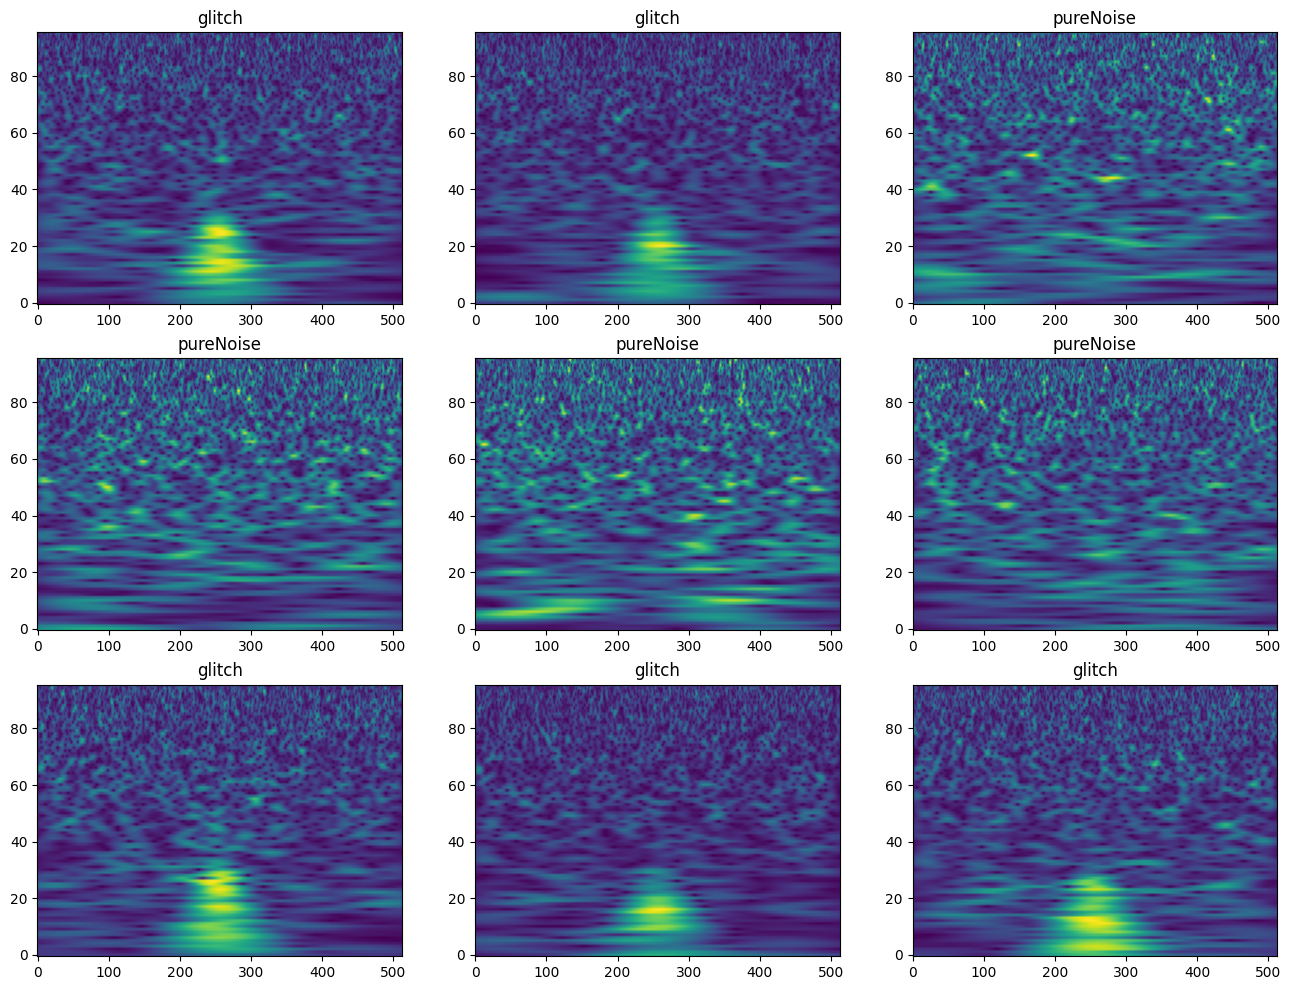

In [12]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = np.load(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img,origin='lower',aspect='auto')
    


## Split

In [13]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.1,
                                          stratify=labels,
                                          random_state=seed)

/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

In [14]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 1440
Validation Data: 160
Test Data: 400


## Image Augmentation

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # transforms.ToTensor(),
    ]
)


## Load Datasets

In [16]:
# for contrastive loss
class stationaryDataset(Dataset):
    def __init__(self, refWGNinTensor, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.refWGNinTensor = refWGNinTensor

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = np.load(img_path)

        img = torch.tensor(img).permute(2,0,1).float()
        # print(img.shape)
        
        img_transformed = self.transform(img)
        refWGNinTensor = self.transform(self.refWGNinTensor)
        
        if 'pureNoise' in img_path:
            label = 0
        else:
            label = 1


        return refWGNinTensor,img_transformed, torch.from_numpy(np.array([int(label!=0)],dtype=np.float32))



# class stationaryDataset(Dataset):
#     def __init__(self, file_list, transform=None):
#         self.file_list = file_list
#         self.transform = transform

#     def __len__(self):
#         self.filelength = len(self.file_list)
#         return self.filelength

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = np.load(img_path)

#         img = torch.tensor(img).permute(2,0,1)
#         # print(img.shape)
#         img_transformed = self.transform(img).float()

#         if 'pureNoise' in img_path:
#             label = 0
#         else:
#             label = 1


#         return img_transformed, label


In [38]:
# train_data = stationaryDataset(train_list, transform=train_transforms)
# valid_data = stationaryDataset(valid_list, transform=test_transforms)
# test_data = stationaryDataset(test_list, transform=test_transforms)

refWGNpath = '/home/guoyiyang/github_repo/vit-pytorch/examples/data4preTrained/test/pureNoise_cqtRGB_SNR=1_3.npy'
refWGNinTensor = np.load(refWGNpath)
refWGNinTensor = torch.tensor(refWGNinTensor).permute(2,0,1).float()

train_data = stationaryDataset(refWGNinTensor,train_list, transform=train_transforms)
valid_data = stationaryDataset(refWGNinTensor,valid_list, transform=test_transforms)
test_data = stationaryDataset(refWGNinTensor,test_list, transform=test_transforms)

In [18]:
data1,data, labels = test_data[0]
print(data.shape)

torch.Size([3, 224, 224])


/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [20]:
print(len(train_data), len(train_loader))

1440 23


In [21]:
print(len(valid_data), len(valid_loader))

160 3


## Efficient Attention

### Linformer

In [22]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [23]:
# model = ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=2,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)

In [24]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.ViT = ViT(
        dim=128,
        image_size=224,
        patch_size=32,
        num_classes=2,
        transformer=efficient_transformer,
        channels=3,
        )


    def forward_once(self, x):
        output = self.ViT(x)

        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

model = SiameseNetwork().to(device)



In [25]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Training

In [26]:
# # loss function
# criterion = nn.CrossEntropyLoss()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:
# Contrastive loss
criterion = ContrastiveLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [28]:
epoch_loss_all = []
epoch_accuracy_all = []
epoch_valAcc_all = []
epoch_ValLoss_all = []

### Classification

In [29]:
# for epoch in range(epochs):
#     epoch_loss = 0
#     epoch_accuracy = 0

#     for data, label in tqdm(train_loader):
#         data = data.to(device)
#         label = label.to(device)

#         output = model(data)
#         loss = criterion(output, label)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         acc = (output.argmax(dim=1) == label).float().mean()
#         epoch_accuracy += acc / len(train_loader)
#         epoch_loss += loss / len(train_loader)
#     epoch_loss_all.append(epoch_loss.cpu().detach().numpy())
#     epoch_accuracy_all.append(epoch_accuracy)
#     with torch.no_grad():
#         epoch_val_accuracy = 0
#         epoch_val_loss = 0
#         for data, label in valid_loader:
#             data = data.to(device)
#             label = label.to(device)

#             val_output = model(data)
#             val_loss = criterion(val_output, label)

#             acc = (val_output.argmax(dim=1) == label).float().mean()
#             epoch_val_accuracy += acc / len(valid_loader)
#             epoch_val_loss += val_loss / len(valid_loader)
#         epoch_ValLoss_all.append(epoch_val_loss.cpu().detach().numpy())
#         epoch_valAcc_all.append(epoch_val_accuracy)
#     print(
#         f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
#     )


### Contrastive loss

In [30]:

euclidean_distance_All = []
euclidean_distance_same = []
euclidean_distance_diff = []

In [31]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_dis = 0
    for refWGN, data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        refWGN = refWGN.to(device)
        output1,output2 = model(refWGN,data)
        
        loss = criterion(output1, output2, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        euclidean_distance = F.pairwise_distance(output1, output2)
        epoch_dis += euclidean_distance.sum() / len(train_loader)
        # if label==0:
        #     euclidean_distance_same.append(euclidean_distance.item())
        # else:
        #     euclidean_distance_diff.append(euclidean_distance.item())
        # acc = (output.argmax(dim=1) == label).float().mean()
        # epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    epoch_loss_all.append(epoch_loss.cpu().detach().numpy())
    # epoch_accuracy_all.append(epoch_accuracy)
    with torch.no_grad():
        # epoch_val_accuracy = 0
        epoch_val_dis = 0
        epoch_val_loss = 0
        for refWGN,data, labels in valid_loader:
            data = data.to(device)
            labels = labels.to(device)
            refWGN = refWGN.to(device)
            val_output1,val_output2 = model(refWGN,data)
            val_loss = criterion(val_output1, val_output2, labels)

            euclidean_distance = F.pairwise_distance(val_output1, val_output2)
            epoch_val_dis += euclidean_distance.sum() / len(train_loader)

            # acc = (val_output.argmax(dim=1) == label).float().mean()
            # epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
        epoch_ValLoss_all.append(epoch_val_loss.cpu().detach().numpy())
        # epoch_valAcc_all.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - dis: {epoch_dis:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_dis:.4f}\n"
    )
torch.save(model.state_dict(), Config.weights_dir+'Contrastive_epoch_{}.pth'.format(epoch))


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.1456 - dis: 24.6079 - val_loss : 0.1366 - val_acc: 9.0455



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0799 - dis: 113.9445 - val_loss : 0.0538 - val_acc: 14.6528



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0489 - dis: 154.2449 - val_loss : 0.0224 - val_acc: 15.3244



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0356 - dis: 187.7857 - val_loss : 0.0207 - val_acc: 21.6385



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.0412 - dis: 209.6312 - val_loss : 0.0100 - val_acc: 21.1392



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.0268 - dis: 240.4076 - val_loss : 0.0064 - val_acc: 25.8889



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.0319 - dis: 239.4520 - val_loss : 0.0191 - val_acc: 18.4124



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.0429 - dis: 196.0397 - val_loss : 0.0088 - val_acc: 21.0847



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.0277 - dis: 208.0162 - val_loss : 0.0088 - val_acc: 20.3549



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.0412 - dis: 208.3432 - val_loss : 0.0200 - val_acc: 24.2728



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.0299 - dis: 206.7811 - val_loss : 0.0108 - val_acc: 24.2145



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.0281 - dis: 224.9126 - val_loss : 0.0040 - val_acc: 26.0916



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.0257 - dis: 239.3580 - val_loss : 0.0076 - val_acc: 27.8864



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.0246 - dis: 216.7086 - val_loss : 0.0096 - val_acc: 25.4800



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.0363 - dis: 204.6584 - val_loss : 0.0065 - val_acc: 23.6521



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.0252 - dis: 216.9862 - val_loss : 0.0039 - val_acc: 26.2662



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.0483 - dis: 201.5090 - val_loss : 0.0103 - val_acc: 20.5190



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.0289 - dis: 126.4897 - val_loss : 0.0052 - val_acc: 16.6252



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.0294 - dis: 156.5857 - val_loss : 0.0068 - val_acc: 22.9325



  0%|          | 0/23 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.0269 - dis: 197.1666 - val_loss : 0.0079 - val_acc: 25.3830



In [32]:

euclidean_distance_All = []
euclidean_distance_same = []
euclidean_distance_diff = []

In [39]:
refWGNinTensor_trans = test_transforms(refWGNinTensor).to(device)
for lp in range(len(test_list)):
    test_data = np.load(test_list[lp])
    test_data = torch.tensor(test_data).permute(2,0,1).float()
    test_data = test_transforms(test_data)
    test_data = test_data.to(device)
    # print(test_data.shape)
    if 'pureNoise' in test_list[lp]:
        label = 0
    else:
        label = 1
    with torch.no_grad():
        output1,output2 = model(refWGNinTensor_trans.unsqueeze(0),test_data.unsqueeze(0))
        euclidean_distance = F.pairwise_distance(output1, output2)
        if label==0:
            euclidean_distance_same.append(euclidean_distance.item())
        else:
            euclidean_distance_diff.append(euclidean_distance.item())

    

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
# Plot the distribution of dis of 2 labels 

# Label 0
plt.hist(euclidean_distance_same,label='same class')
# Label 1
plt.hist(euclidean_distance_diff,label='diff class')
plt.title(str(300)+' samples from '+str(400)+' data')
plt.xlabel('distance')
plt.ylabel('times')
plt.legend()

In [ ]:
# plot loss of the figure
plt.plot(range(epochs),epoch_loss_all)
# print(type())
# fig, ax1 = plt.subplots()
# # Plot the first set of data with left y-axis
# ax1.plot(np.arange((np.mean(acc,1)).shape[0]),np.mean(acc,1),marker='o',color='red',label='train')
# ax1.plot(np.mean(acc,1),color='cyan')
# ax1.set_xlabel('epoch')
# ax1.set_ylabel('acc_train', color='red')
# ax1.tick_params('y', colors='red')

# # Create a twin Axes sharing the x-axis
# ax2 = ax1.twinx()

# # Plot the second set of data with right y-axis
# ax2.plot(np.mean(val_acc,1),'o',label='est')
# ax2.plot(np.mean(val_acc,1))
# ax2.set_xlabel('epoch')
# ax2.set_ylabel('acc_test', color='blue')
# ax2.tick_params('y', colors='blue')
# ax1.legend()
# ax2.legend()
# # 
# plt.figure()
# plt.plot(myLoss)
# plt.xlabel('epoch')
# plt.ylabel('loss')


In [ ]:

for lp in range(len(epoch_accuracy_all)):
    epoch_accuracy_all[lp] =epoch_accuracy_all[lp].cpu().detach().numpy()
for lp in range(len(epoch_valAcc_all)):
    epoch_valAcc_all[lp] =epoch_valAcc_all[lp].cpu().detach().numpy()


In [ ]:
# Plotting
print(type)
fig, ax1 = plt.subplots()
ax1.plot(np.arange(len(epoch_accuracy_all)), epoch_accuracy_all, marker='o', color='red', label='train')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Test Accuracy', color='black')
ax1.tick_params('y', colors='black')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(np.arange(len(epoch_valAcc_all)), epoch_valAcc_all, marker='o', color='blue', label='valid')
# ax2.plot(np.arange(len(epoch_loss_all)), epoch_loss_all, color='green', label='train_loss')
# ax2.plot(np.arange(len(epoch_ValLoss_all)), epoch_ValLoss_all, color='orange', label='valid_loss')
ax2.set_ylabel('Valid Accuracy', color='black')
ax2.tick_params('y', colors='black')
ax2.legend()

plt.show()

In [ ]:
# torch.save(model.state_dict(), Config.weights_dir+'epoch_{}.pth'.format(epoch))